# GOES-R DataJam: Setup and Data Access

## Environment Setup

### GitHub


### Creating a Jupyter Notebook

### Install Packages

In [ ]:
# install packages using pip

In [1]:
# import packages
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import boto3
import fsspec
from botocore import UNSIGNED
from botocore.config import Config

## Data Access

In [ ]:
# setup AWS credentials
!export AWS_ACCESS_KEY_ID=your_access_key
!export AWS_SECRET_ACCESS_KEY=your_secret_key


In [2]:
# set up access to S3 bucket
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
paginator = s3.get_paginator("list_objects_v2")
page_iterator = paginator.paginate(Bucket="noaa-goes16", Prefix="ABI-L2-CMIPC/2021/001/18/") 

S3_HEADER = "s3://noaa-goes16/"
files_mapper = [S3_HEADER + f["Key"] for page in page_iterator for f in page["Contents"]]

In [11]:
files_mapper[0]

's3://noaa-goes16/ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01_G16_s20210011801176_e20210011803549_c20210011804063.nc'

In [12]:
files_mapper[1]

's3://noaa-goes16/ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01_G16_s20210011806176_e20210011808549_c20210011809018.nc'

In [12]:
# open data file
# libraries needed: netcdf4, pydap
url_blue = files_mapper[1] +"#mode=bytes"
ds_blue = xr.open_dataset(url_blue)
ds_blue

<xarray.Dataset>
Dimensions:                                           (y: 3000, x: 5000,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1282 ... ...
  * x                                                 (x) float64 -0.1013 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/35)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-01-01T18:06:17.6Z
    time_coverage_end:         2021-01-01T18:08:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        01c42375-da6d-4635-8f1f-7fbf0f4b31f0

### What is a CMI file?

### ABI Imagery Bands

### Plotting an Image

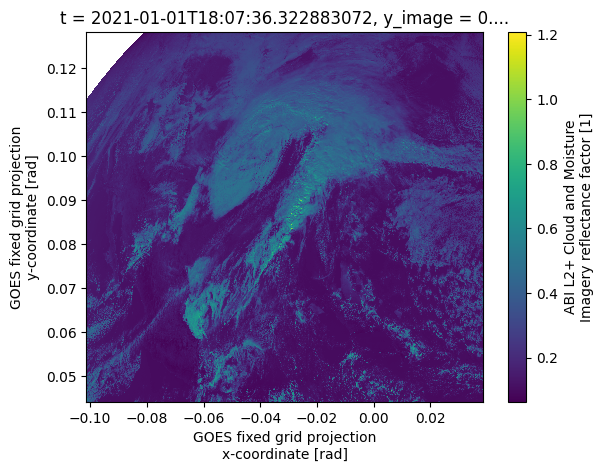

In [13]:
# plot a simple image with one band
ds_blue["CMI"].plot()

In [14]:
# inspect other channels

# red
url_red = get_url_for_prefix("ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C02")
ds_red = xr.open_dataset(url_red) # MAY NEED FSSPEC

# vegetation ("veggie") AKA green
url_veggie = get_url_for_prefix("ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C03")
ds_veggie = xr.open_dataset(url_veggie) # MAY NEED FSSPEC

NameError: name 'get_url_for_prefix' is not defined

In [ ]:
display(ds_blue["CMI"].values.shape)
display(ds_red["CMI"].values.shape)
display(ds_veggies["CMI"].values.shape)

In [ ]:
# resample red 
red_vals = ds_red["CMI"].values
shape = ds_blue.values.shape

sh = shape[0], red_vals.shape[0]//shape[0], shape[1], red_vals.shape[1]//shape[1]
ds_red_reshape = red_vals.reshape(sh).mean(-1).mean(1)

In [ ]:
ds_red_reshape.shape

In [ ]:
# plot with all colors
geocolor = np.stack(ds_red_reshape, ds_veggie, ds_blue, axis = 2)

fig = plt.figure(figsize=(10,10), dpi = 200)
img = plt.imshow(geocolor)
plt.title("GeoColor Image")
plt.show()

### Plotting an Animation